# Boxplot of top five up- and downregulated genes

In [1]:
suppressMessages({library(ggpubr)
                  library(tidyverse)
                  library(data.table)})

In [2]:
save_ggplots <- function(p, fn, w=7, h=7){
    for(ext in c('.svg', '.png', '.pdf')){
        ggsave(p, filename=paste0(fn, ext), width=w, height=h)
    }
}


add_symnum <- function(res){
    symnum.args <- list(cutpoints = c(0, 0.0001, 0.001, 0.01, 0.05,  1),
                        symbols = c("****", "***", "**", "*",  "ns"))
    symnum.args$x <- res$adj.P.Val
    pvalue.signif <- do.call(stats::symnum, symnum.args) %>%
        as.character()
    pvalue.format <- format.pval(res$adj.P.Val, digits = 2)
    res <- res %>%
        dplyr::ungroup() %>%
        mutate(FDR = pvalue.format, p.signif = pvalue.signif)
    return(res)
}


## Select most significant DEGs, up- and downregulated

In [3]:
genes = fread('../../metrics_summary/_m/female_specific_DE_genes.txt') %>%
    filter(Type == 'gene') %>% add_symnum()
up_genes = genes %>% filter(t > 0) %>% mutate('Direction'='Upregulated') %>% head(5)
down_genes = genes %>% filter(t < 0) %>% mutate('Direction'='Downregulated') %>% head(5)
sig_genes = bind_rows(up_genes, down_genes) %>% mutate_at(vars(Direction), as.factor)

for(xx in seq_along(sig_genes$Symbol)){
    sig_genes$New_ID[xx] <- ifelse(sig_genes$Symbol[xx] == '', 
                                   as.character(sig_genes$ensemblID[xx]), 
                                   as.character(sig_genes$Symbol[xx]))
}
sig_genes

Feature,gencodeID,Symbol,ensemblID,Chrom,logFC,t,adj.P.Val,Male_Pval,Male_FDR,Type,FDR,p.signif,Direction,New_ID
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<fct>,<chr>
ENSG00000153132.12,ENSG00000153132.12,CLGN,ENSG00000153132,chr4,0.3899370,5.559139,0.0001230954,0.28301989,0.3137106,gene,0.00012,***,Upregulated,CLGN
ENSG00000179083.6,ENSG00000179083.6,FAM133A,ENSG00000179083,chrX,0.2612679,5.004488,0.0005346726,0.27201859,0.3029729,gene,0.00053,***,Upregulated,FAM133A
ENSG00000165733.7,ENSG00000165733.7,BMS1,ENSG00000165733,chr10,0.1509181,4.986552,0.0005346726,0.16978740,0.2054279,gene,0.00053,***,Upregulated,BMS1
ENSG00000183023.18,ENSG00000183023.18,SLC8A1,ENSG00000183023,chr2,0.2458194,4.925477,0.0006315429,0.08275941,0.1089631,gene,0.00063,***,Upregulated,SLC8A1
ENSG00000236268.5,ENSG00000236268.5,LINC01361,ENSG00000236268,chr1,0.4045322,4.865744,0.0006999462,0.11063178,0.1404042,gene,0.00070,***,Upregulated,LINC01361
ENSG00000268049.1,ENSG00000268049.1,,ENSG00000268049,chr19,-0.3193858,-4.775427,0.0007897721,0.17518709,0.2112221,gene,0.00079,***,Downregulated,ENSG00000268049
ENSG00000083812.11,ENSG00000083812.11,ZNF324,ENSG00000083812,chr19,-0.1442091,-4.484918,0.0016882306,0.12037745,0.1511090,gene,0.00169,**,Downregulated,ZNF324
ENSG00000118960.12,ENSG00000118960.12,HS1BP3,ENSG00000118960,chr2,-0.1691578,-4.440011,0.0016936494,0.22387717,0.2580806,gene,0.00169,**,Downregulated,HS1BP3
ENSG00000114554.11,ENSG00000114554.11,PLXNA1,ENSG00000114554,chr3,-0.2573617,-4.418491,0.0018049975,0.39674894,0.4151558,gene,0.00180,**,Downregulated,PLXNA1


## Load phenotypes

In [4]:
pheno_file = paste0('/ceph/users/jbenja13/projects/sex_sz_ria/',
                    'input/commonMind/phenotypes/combine_files/',
                    '_m/CMC_phenotypes_all.csv')
pheno = fread(pheno_file) %>% 
    filter(Sex %in% c("XX", "XY"), 
           Dx %in% c("Control", "SCZ")) %>%
    mutate_if(is.character, as.factor) %>%
    select(c(Individual_ID, "RNAseq:Sample_RNA_ID", Dx, Sex))
colnames(pheno)[2] <- "SampleID"
levels(pheno$Sex) <- c("Female", "Male")
levels(pheno$Dx) <- c("CTL", "SZ")
pheno %>% head(2)

Individual_ID,SampleID,Dx,Sex
<fct>,<fct>,<fct>,<fct>
CMC_HBCC_003,CMC_HBCC_RNA_PFC_3158,CTL,Male
CMC_HBCC_005,CMC_HBCC_RNA_PFC_3152,CTL,Male


## Load residualized expression

In [5]:
res_file = paste0('/ceph/users/jbenja13/projects/sex_sz_ria/analysis/', 
                 'interaction_sex_sz/cmc_dlpfc/_m/genes/residualized_expression.tsv')
resdf0 = fread(res_file) %>% 
    filter(V1 %in% sig_genes$gencodeID) %>% 
    column_to_rownames(var="V1") %>% t %>% 
    as.data.frame %>% rownames_to_column() %>% 
    rename(SampleID=rowname) %>% 
    mutate_at("SampleID", as.factor)
resdf0[1:2, 1:5]

Warning message in fread(res_file):
“Detected 858 column names but the data has 859 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


,SampleID,ENSG00000083812.11,ENSG00000114554.11,ENSG00000118960.12,ENSG00000153132.12
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,MSSM_RNA_PFC_1,-1.32589368,-0.6892169,0.2111176,-0.9358592
2,MSSM_RNA_PFC_2,0.00148675,-0.1092207,1.0004576,0.6763067


### Merge and melt dataframe

In [6]:
df <- inner_join(pheno, resdf0, by="SampleID") %>%
    select(c('SampleID', 'Sex', 'Dx', starts_with('ENSG'))) %>% 
    pivot_longer(-c(SampleID, Sex, Dx), 
                 names_to='gencodeID', values_to="Res") %>% 
    inner_join(sig_genes, by='gencodeID') %>% 
    mutate_at(vars("New_ID", "Symbol", "gencodeID"), as.factor)
df$New_ID = with(df, reorder(New_ID, adj.P.Val, median))
df$Dx <- fct_drop(df$Dx)
dim(df)
df[1:2, 1:10]

[1] 8580   19

SampleID,Sex,Dx,gencodeID,Res,Feature,Symbol,ensemblID,Chrom,logFC
<fct>,<fct>,<fct>,<fct>,<dbl>,<chr>,<fct>,<chr>,<chr>,<dbl>
CMC_HBCC_RNA_PFC_3158,Male,CTL,ENSG00000083812.11,-0.4536485,ENSG00000083812.11,ZNF324,ENSG00000083812,chr19,-0.1442091
CMC_HBCC_RNA_PFC_3158,Male,CTL,ENSG00000114554.11,0.2280048,ENSG00000114554.11,PLXNA1,ENSG00000114554,chr3,-0.2573617


### Initial ggplot with ggpubr

Warning message:
“Ignoring unknown aesthetics: xmin, xmax, annotations, y_position”


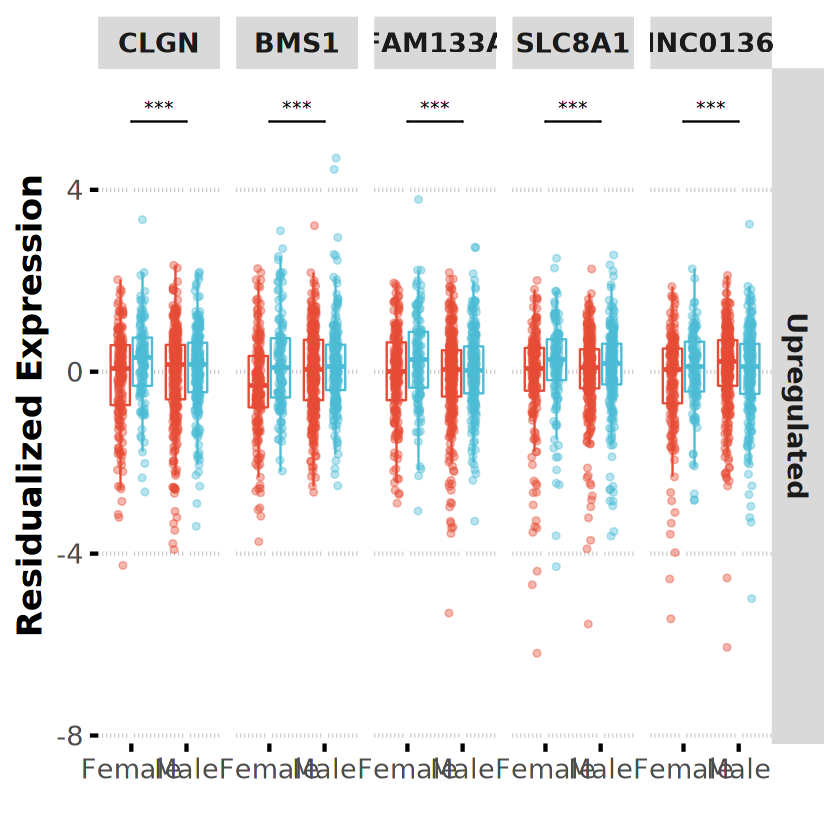

In [7]:
tmp = sig_genes %>% 
    mutate(group1='Female', group2='Male', y_pos=5.5) %>% 
    filter(Direction == 'Upregulated') %>%
    mutate_if(is.character, as.factor)

bxp_up <- df %>% filter(Direction=="Upregulated") %>%
        ggboxplot(x="Sex", y="Res", facet.by=c("Direction", "New_ID"), 
                  add='jitter', color="Dx", xlab='', palette="npg", 
                  panel.labs.font=list(face='bold'), legend="", 
                  ylab='Residualized Expression', ylim=c(-7.5, 6),
                  add.params=list(alpha=0.4), outlier.shape=NA, 
                  ggtheme=theme_pubclean(base_size=20)) +
         geom_signif(data=tmp, tip_length = 0,
                     aes(xmin=group1, xmax=group2, annotations=p.signif, y_position = y_pos), 
                     manual=TRUE) + 
         font("xy.title", face="bold") + font("legend.title", face="bold")
         
bxp_up

Warning message:
“Ignoring unknown aesthetics: xmin, xmax, annotations, y_position”


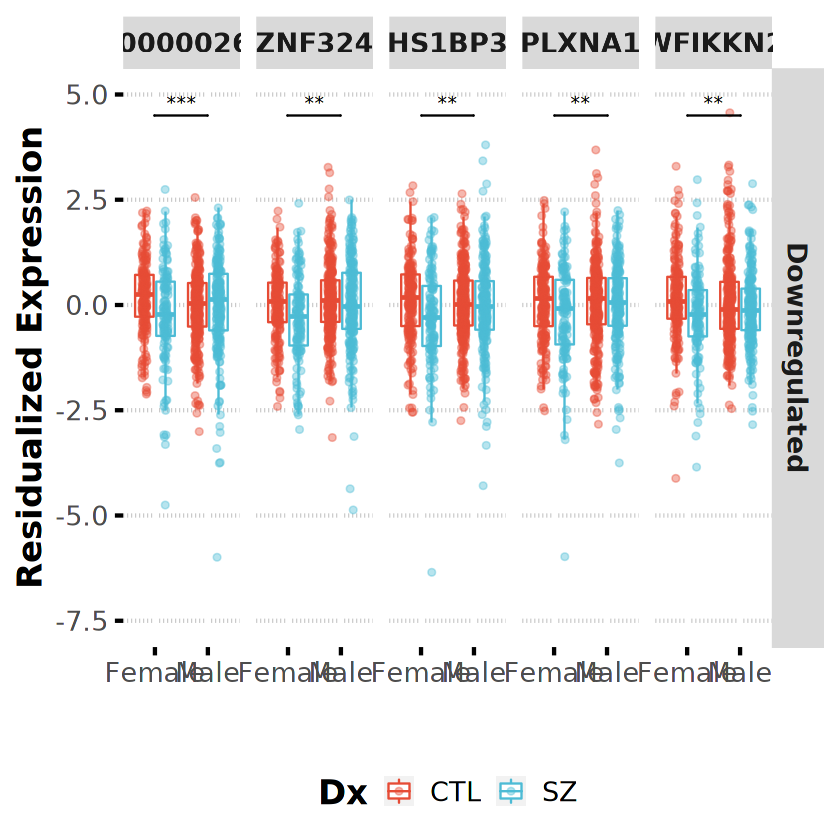

In [8]:
tmp = sig_genes %>% 
    mutate(group1='Female', group2='Male', y_pos=4.5) %>% 
    filter(Direction == 'Downregulated') %>%
    mutate_if(is.character, as.factor)

bxp_down <- df %>% filter(Direction=="Downregulated") %>%
        ggboxplot(x="Sex", y="Res", facet.by=c("Direction", "New_ID"), 
                  add='jitter', color="Dx", xlab='', palette="npg", 
                  panel.labs.font=list(face='bold'), legend="bottom", 
                  ylab='Residualized Expression', ylim=c(-7.5, 5),
                  add.params=list(alpha=0.4), outlier.shape=NA, 
                  ggtheme=theme_pubclean(base_size=20)) +
         geom_signif(data=tmp, tip_length = 0,
                     aes(xmin=group1, xmax=group2, annotations=p.signif, y_position = y_pos), 
                     manual=TRUE) + 
         font("xy.title", face="bold") + font("legend.title", face="bold")
         
bxp_down

### Annotate figure

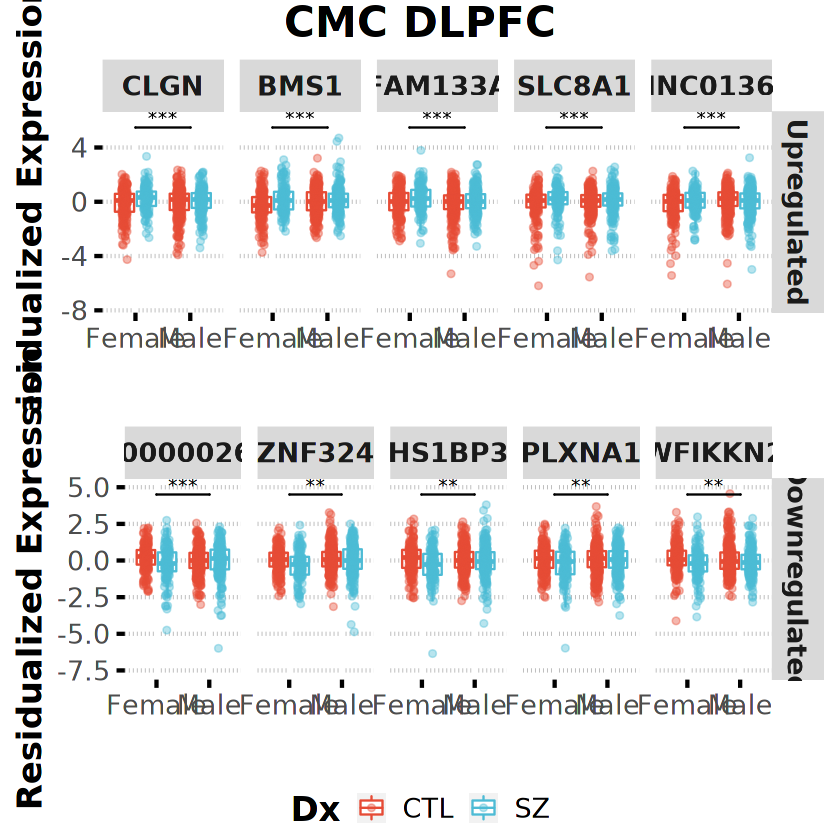

In [9]:
figure <- ggarrange(bxp_up, bxp_down, ncol = 1, nrow = 2, 
                    common.legend = TRUE, legend="bottom")
figure <- annotate_figure(figure, top=text_grob("CMC DLPFC", size=25, face='bold'))
figure

In [10]:
save_ggplots(figure, 'femaleSpecific_SZ', 12, 10)

## Session Info

In [11]:
Sys.time()
proc.time()
options(width = 120)
sessioninfo::session_info()

[1] "2021-08-13 10:35:14 EDT"

   user  system elapsed 
 15.367   3.117  43.627 

─ Session info ───────────────────────────────────────────────────────────────────────────────────────────────────────
 setting  value                       
 version  R version 4.0.3 (2020-10-10)
 os       Arch Linux                  
 system   x86_64, linux-gnu           
 ui       X11                         
 language (EN)                        
 collate  en_US.UTF-8                 
 ctype    en_US.UTF-8                 
 tz       America/New_York            
 date     2021-08-13                  

─ Packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────
 package     * version  date       lib source        
 abind         1.4-5    2016-07-21 [1] CRAN (R 4.0.2)
 assertthat    0.2.1    2019-03-21 [1] CRAN (R 4.0.2)
 backports     1.2.1    2020-12-09 [1] CRAN (R 4.0.2)
 base64enc     0.1-3    2015-07-28 [1] CRAN (R 4.0.2)
 broom         0.7.8    2021-06-24 [1] CRAN (R 4.0.3)
 Cairo         1.5-12.2 2020-07-07 [1] CRAN (R 